## Общее описание:

Есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Data scientist-ы компании придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. 

Решено раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. 

Задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

## Описание данных

- `order_id` - id заказа
- `delivery_time` - время доставки в минутах
- `district` - район доставки
- `experiment_group` - экспериментальная группа



### План

**1. Подготовка к работе. Импорт необходимых библиотек и загрузка данных**
   
**2. Предварительный анализ данных**

**3.Построение графиков распределения времени доставки в тестовой и контрольной группах**

**4. Подсчет количества наблюдений в тестовой и контрольной группе**

**5. Выбор стат. теста: проверка выполнения условий на нормальность и подсчет стандартного отклонения в тесте и в контроле**

**6. Проведение стат. теста и сравнение времени доставки в контрольной и тестовой группах**

**7. Вывод о целесообразности внедрения нового алгоритма для курьеров по итогу проведения теста**


<hr style='border: 1px solid'>

## 1. Подготовка к работе. Импорт библиотек и загрузка данных

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy.stats import ttest_ind
%matplotlib inline

In [2]:
df = pd.read_csv('./experiment_lesson_4.csv')

In [3]:
df.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


<hr style='border: 1px solid'>

## 2. Предварительный анализ данных

<b>Проверяем данные на наличие пропущенных значений и строк-дубликатов</b>

In [5]:
df.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

In [6]:
df.isna().sum()

order_id            0
delivery_time       0
district            0
experiment_group    0
dtype: int64

In [7]:
df.loc[df.duplicated()]

,order_id,delivery_time,district,experiment_group


<hr style='border: 1px solid'>

## 3. Строим графики распределения времени доставки в тестовой и контрольной группах

In [14]:
# Для построения графиков нам понадобятся только колонки 'experiment_group' и'delivery_time'

delivery_time = df[['experiment_group','delivery_time']]

In [15]:
# Создаем df с данными тестовой группы

delivery_time_test = df[['experiment_group','delivery_time']].query('experiment_group == "test"')

In [16]:
# Создаем df с данными контрольной группы

delivery_time_control = df[['experiment_group','delivery_time']].query('experiment_group == "control"')

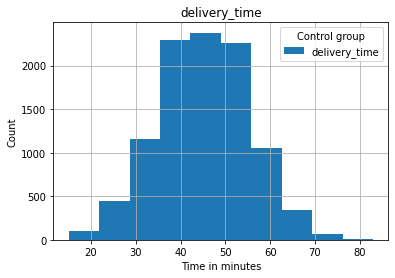

In [27]:
delivery_time_control.hist(column = 'delivery_time', legend=True)
plt.legend(title='Control group')
plt.xlabel("Time in minutes")
plt.ylabel("Count")
plt.show()

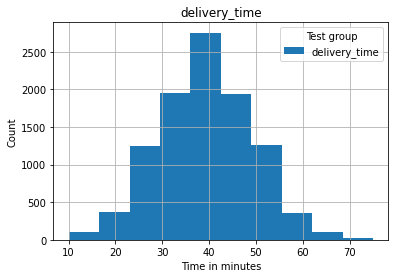

In [28]:
delivery_time_test.hist(column = 'delivery_time', legend=True)
plt.legend(title='Test group')
plt.xlabel("Time in minutes")
plt.ylabel("Count")
plt.show()

<b>По графикам видно, что в обеих группах распределения данных похожи на нормальное, с небольшими отклонениями.
<br>    
Наиболее частым значением времени доставки в тестовой группе является 40 (минут), в контрольной - 50. Далее с помощью стат. теста выясним, являются ли данные различия стат. значимыми.</b>

<hr style='border: 1px solid'>

## 4. Считаем количество наблюдений в тестовой и контрольной группе. Выясняем, на сколько по модулю отличается количество наблюдений в тесте и контроле?

In [14]:
values_counting = df.groupby('experiment_group') \
.agg({'order_id':'count'}).reset_index()

In [15]:
values_counting

,experiment_group,order_id
0,control,10092
1,test,10104


In [11]:
counts_diff = abs(values_counting.iloc[0][1] - values_counting.iloc[1][1] )

In [12]:
counts_diff

12

<b>Кол-во наблюдений в тестовой и контрольной группах по модулю отличается на 12 значений</b>

<hr style='border: 1px solid'>

## 5. Выбираем стат. тест: проверим данные на нормальность и посчитаем стандартные отклонения в тесте и в контроле.

<b>Проверим данные в обеих группах на нормальность распределения и схожесть ст. отклонений. Для проверки данных на нормальность будем использовать тест Агостино-Пирсона по функции scipy.stats.normaltest()</b>

In [13]:
data_test = delivery_time_test.delivery_time

In [14]:
# проверяем нулевую гипотезу на данных с тестовой группой

normaltest(data_test)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [15]:
data_control = delivery_time_control.delivery_time

In [16]:
# проверяем нулевую гипотезу на данных с контрольной группой

normaltest(data_control)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

<b>Вывод: Значения в тестовой группе распределены ненормально, в контрольной группе распределение является нормальным.</b>

In [19]:
# находим ст. отклонение для данных с тестовой группой

st_test = round(data_test.std(), 2)

In [20]:
st_test

9.88

In [21]:
# находим ст. отклонение для данных с контрольной группой
st_control = round(data_control.std(), 2)

In [22]:
st_control

9.99

<b>Вывод: Ст. отклонения в обеих группах схожи.
<br><br>
Учитывая большой объем данных и отсутствие явной ассиметрии в данных обеих групп, можем применить <u>тест Стьюдента</u> для проверки гипотезы об отсутствии стат. значимой разницы <u>в средних</u>.
</b>

<hr style='border: 1px solid'>

## 6. Проводим стат. тест и сравниваем средние в тесте и контроле

<b>
H0 : Новый алгоритм статистически не сокращает среднее время доставки пиццы курьерами.
<br>
H1 :  Новый алгоритм статистически сокращает среднее время доставки пиццы курьерами.
<br>    
    
С помощью функции ttest_ind из пакета scipy проводим тест на наличие стат. значимой разницы во времени доставки между двумя группами.
<br><br>
Устанавливаем уровень значимости на уровне 0.05 (5%).
</b>

In [25]:
ttest_ind(data_test, data_control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

<b>Вывод по итогу теста: Поскольку p-value < 0.05, отвергаем нулевую гипотезу об отсутствии стат. значимых различий в среднем времени доставки пиццы и делаем вывод о наличии такой разницы во времени в пользу тестовой.
<br><br>
Теперь выясняем, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной
</b>

In [65]:
test_mean = data_test.mean()


In [66]:
conrol_mean = data_control.mean()

In [67]:
diff = (test_mean - conrol_mean) / conrol_mean * 100

In [68]:
diff = round(diff, 2)

In [69]:
diff

-13.35

<b>В рамках применения нового алгоритма примерно на 13% сокращается среднее время доставки пиццы.</b>

<hr style='border: 1px solid'>

### 7. Вывод о целесообразности внедрения нового алгоритма для курьеров по итогу проведения теста

<b>Раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.</b>